- 이 파일 셀들을 복사해서 제출 notebook 만든다.
- 이 repo의 src, third-party, ckpt를 압축한다. 
  - ex) submission_files.zip
- 하나의 directory로 업로드 한다.
  - /kaggle/input/submission_files 로 올린다.
  - 압축 알아서 풀려있음

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import argparse
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import sys
import pandas as pd
# 일단 __init__.py 추가해서 이렇게 해놨음.
BASE_PATH='/workspace'
sys.path.append(os.path.join(BASE_PATH, "src"))

# timm as third-party
sys.path.append(os.path.join(BASE_PATH, 'third-party/pytorch-image-models'))

from config import CFG
from factory.dataset_factory import DataSetFactory
from factory.lightning_module_factory import LightningModuleFactory
from train import seed_everything

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# TODO: data dir train/pred 구분.
CFG["dataset_params"]["data_dir"] = os.path.join(BASE_PATH, "data")
CFG["dataset_params"]["preprocess_result_dir"] = os.path.join(BASE_PATH, "data/processed")
CFG["is_prediction"] = True
CFG["reproduce_processed_data"] = False
CFG["threshold"] = 0.357
CFG["dataset_params"]["data_filter"] = "players"

In [4]:
seed_everything(CFG['seed'])
device_str = "cpu"
if torch.cuda.is_available():
    device_str = "cuda"
device_str

'cuda'

In [5]:
saved_model_path = os.path.join(
    BASE_PATH, 
    "epoch-6-step-44415-020203.ckpt"
)

In [6]:

model_name = f"{CFG['model_name']}-{CFG['model_version']}"
dataset_params = CFG['dataset_params']
model_params = CFG['model_params']
data_module = DataSetFactory.get_dataset(name=model_name,
                                            params=dataset_params)
lightning_module = LightningModuleFactory.get_lightning_module(name=model_name,
                                                                params=model_params)

trainer = pl.Trainer(max_epochs=CFG["epochs"],
                        accelerator=device_str,
                        devices=1 if device_str != "cpu" else None,
                        logger=False
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
predictions = trainer.predict(
    model=lightning_module, 
    datamodule=data_module,
    ckpt_path=saved_model_path)


====== [Preprocess] ======
- is_prediction: True
- run_type: test
------ [Loading Metadata] ------
------ [ffmpeg] ------
ffmpeg frames test


100%|██████████| 4/4 [00:00<00:00, 6288.31it/s]

video2frames already exists.. skip



You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /workspace/epoch-4-step-31725-012914.ckpt


------ [Preprocess helmet sensor data] ------
df_filtered already exists.. skip
------ [Setup dataset] ------
====== Generating dataset  ======
- stage: predict
------ [Load metadata] ------
-- Label count predict: 
contact
0    6631
Name: contact, dtype: int64
- predict_dataset_size: 2319


Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../epoch-4-step-31725-012914.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/epoch-4-step-31725-012914.ckpt


Predicting DataLoader 0: 100%|██████████| 73/73 [00:09<00:00,  7.52it/s]


In [43]:
df_filtered = data_module.dataset_pred.df

In [44]:
y_pred = []
for p in predictions:
    y_pred += p.tolist() 
y_pred_np = np.array(y_pred)

In [45]:
len(y_pred_np), len(df_filtered)

(2319, 2319)

In [46]:
df_filtered['contact'] = (y_pred_np >= CFG["threshold"]).astype('int')
df_filtered.groupby("contact")["contact"].count()

contact
0    1771
1     548
Name: contact, dtype: int64

In [47]:

sub = pd.read_csv(os.path.join(CFG["dataset_params"]["data_dir"], 'sample_submission.csv'))

sub = sub.drop("contact", axis=1).merge(df_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


# players - Ground 분리


In [48]:
CFG["threshold"] = 0.209
CFG["dataset_params"]["data_filter"] = "ground-only"
saved_model_path = os.path.join(
    BASE_PATH, 
    "epoch-4-step-50850-012821.ckpt"
)

model_name = f"{CFG['model_name']}-{CFG['model_version']}"
dataset_params = CFG['dataset_params']
model_params = CFG['model_params']
data_module = DataSetFactory.get_dataset(name=model_name,
                                            params=dataset_params)

lightning_module = LightningModuleFactory.get_lightning_module(name=model_name,
                                                                params=model_params)

trainer = pl.Trainer(max_epochs=CFG["epochs"],
                        accelerator=device_str,
                        devices=1 if device_str != "cpu" else None,
                        logger=False
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
predictions = trainer.predict(
    model=lightning_module, 
    datamodule=data_module,
    ckpt_path=saved_model_path)


====== [Preprocess] ======
- is_prediction: True
- run_type: test
------ [Loading Metadata] ------
------ [ffmpeg] ------
ffmpeg frames test


100%|██████████| 4/4 [00:00<00:00, 26886.56it/s]
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


video2frames already exists.. skip
------ [Preprocess helmet sensor data] ------
df_filtered already exists.. skip
------ [Setup dataset] ------
====== Generating dataset  ======
- stage: predict
------ [Load metadata] ------
-- Label count predict: 
contact
0    6631
Name: contact, dtype: int64


Restoring states from the checkpoint path at /workspace/epoch-4-step-50850-012821.ckpt


- predict_dataset_size: 4312


Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../epoch-4-step-50850-012821.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/epoch-4-step-50850-012821.ckpt


Predicting DataLoader 0: 100%|██████████| 135/135 [00:17<00:00,  7.73it/s]


In [50]:
df_filtered_2 = data_module.dataset_pred.df

In [51]:
y_pred = []
for p in predictions:
    y_pred += p.tolist() 
y_pred_np = np.array(y_pred)

len(y_pred_np), len(df_filtered_2)

(4312, 4312)

In [52]:

df_filtered_2['contact'] = (y_pred_np >= CFG["threshold"]).astype('int')
df_filtered_2.groupby("contact")["contact"].count()

contact
0    4069
1     243
Name: contact, dtype: int64

In [53]:
df_concat = pd.concat([df_filtered[["contact_id", "contact"]], df_filtered_2[["contact_id", "contact"]]])
df_concat.groupby("contact").count()

,contact_id
contact,
0,5840
1,791


In [54]:

sub = pd.read_csv(os.path.join(CFG["dataset_params"]["data_dir"], 'sample_submission.csv'))

sub = sub.drop("contact", axis=1).merge(df_concat[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


# test for threshold

In [7]:
trainer.test(model=lightning_module, datamodule=data_module,
    ckpt_path=saved_model_path)

====== [Preprocess] ======
- is_prediction: True
- run_type: test
------ [Loading Metadata] ------
------ [ffmpeg] ------
ffmpeg frames test


100%|██████████| 4/4 [00:00<00:00, 10466.14it/s]
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


video2frames already exists.. skip
------ [Preprocess helmet sensor data] ------
df_filtered already exists.. skip
------ [Setup dataset] ------
====== Generating dataset  ======
- stage: test
------ [Load metadata] ------


Restoring states from the checkpoint path at /workspace/epoch-6-step-44415-020203.ckpt
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../epoch-6-step-44415-020203.ckpt`


-- num_videos: 24/240
-- Label count test: 
contact
0    58681
1     6696
Name: contact, dtype: int64
- test_dataset_size: 23467


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /workspace/epoch-6-step-44415-020203.ckpt


Testing DataLoader 0: 100%|██████████| 734/734 [02:16<00:00,  5.37it/s] ====== [Test contact counts] ======
-- preds  : 11056.0/23467
-- labels : 4690.0/23467

Testing DataLoader 0: 100%|██████████| 734/734 [02:16<00:00,  5.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_step         0.7164528965950012
        test_loss           0.7745419144630432
        test_mcc            0.49877333641052246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7745419144630432,
  'test_acc_step': 0.7164528965950012,
  'test_mcc': 0.49877333641052246}]

In [8]:
outputs_cat = torch.cat(trainer.model.last_test_output)
y, labels = outputs_cat[:, 0], outputs_cat[:, 1]
thresholds = np.arange(0.0,1.0, 0.001)

mccs = []
ratio_y = []
ratio_labels = []
for threshold in thresholds:

    preds = (y > threshold).float()
    # print(
    #     f"====== [Test contact counts] ======\n"
    #     f"-- preds  : {torch.sum(preds)}/{len(preds)}\n"
    #     f"-- labels : {torch.sum(labels)}/{len(labels)}\n")

    mcc_loss = trainer.model.mcc_loss(preds, labels)
    mcc = 1.0 - mcc_loss
    # print(mcc.item())
    mccs.append(mcc.item())
    ratio_y.append(torch.sum(preds).item()/len(preds))
    ratio_labels.append(torch.sum(labels).item()/len(preds))
    
mccs = np.array(mccs)
ratio_y = np.array(ratio_y)
ratio_labels = np.array(ratio_labels)

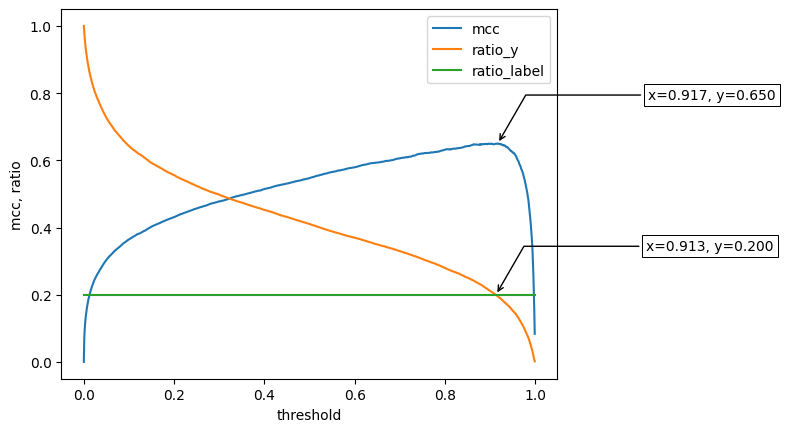

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(thresholds, mccs, label="mcc") 
ax.plot(thresholds, ratio_y, label="ratio_y") 
ax.plot(thresholds, ratio_labels, label="ratio_label")
ax.set_xlabel("threshold")
ax.set_ylabel("mcc, ratio")
ax.legend()

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="offset points",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(200, 40), **kw)
    

annot_max(thresholds, mccs)
annot_max(thresholds, ratio_labels - np.abs(ratio_y - ratio_labels))
plt.show()